In [1]:
import pandas as pd
import numpy as np
import tkinter
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib
#matplotlib inline
#%matplotlib notebook
import seaborn as sns
from random import randint
pd.set_option('display.max_columns', None)
from bokeh.io import output_notebook
output_notebook()
from bokeh.io import output_notebook,show
from bokeh.plotting import figure, ColumnDataSource
import calendar
from bokeh.models import HoverTool
#from bokeh.transform import dodge

Loading BokehJS ...

In [2]:
movies_df=pd.read_csv('final_movie_data_df.csv',encoding='Latin')

On analyzing the data, i found that there are a lot of rows (1576 rows out of a total of 2587 rows) that do not have the actor or director score. Unfortunately, Amazon has changed the IMDB datasets hosted on S3 and as a result the IMDBPy function to get movie details does not work any more. So i will not be able to use IMDBPy to get the details untill this issue is fixed. More details of this issue can be found here:
https://github.com/alberanid/imdbpy/issues/103
For now, i will proceed with whatever data that is available, i.e. around 1000 rows. Will come back later if the issue is fixed or find alternate ways to find this data

In [3]:
len(movies_df[np.isnan(movies_df['actor1_score'])])

1576

In [4]:
#remove the rows that do not contain the actor scores
movies_df=movies_df[~(np.isnan(movies_df['actor1_score']))]

In [153]:
movies_df.columns

Index(['imdbId', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
       'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western', 'actor1_gender', 'actor1_name', 'actor1_score',
       'actor2_gender', 'actor2_name', 'actor2_score', 'actor3_gender',
       'actor3_name', 'actor3_score', 'actor4_gender', 'actor4_name',
       'actor4_score', 'director', 'director_score', 'found', 'genres', 'kind',
       'movieBudget', 'movieId', 'movie_4th_wknd_bo', 'movie_details', 'plot',
       'release_date', 'studio', 'title', 'tmdbId', 'year', 'year_orig',
       'prof_loss', 'pcnt_prof_loss', 'release_date_upd', 'Apr', 'Aug', 'Dec',
       'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep',
       'actor1_male', 'actor1_female', 'actor2_male', 'actor2_female',
       'actor3_male', 'actor3_female', 'actor4_male', 'actor4_female'],
      dtype='object')

In [5]:
def fix_release_dates(date_string,year,title):
    #function to fix the release dates
    try:
        if pd.isnull(date_string) | ('NoReleaseDates' in str(date_string)):
            #could not find release dates for around 400 of the movies
            #will default those to 15the of a random month of the release year
            def_date='15-'+str(randint(1,12))+'-'+str(int(year))
            #print('default date:',def_date)
            conv_date=pd.to_datetime(def_date)
        elif '0 ' in str(date_string)[0:2]:
            #some release dates have the date as '0 January 2010'
            #converting those to 01 January 2010
            def_date='01 '+date_string[2:]
            conv_date=pd.to_datetime(def_date)
        else:
            conv_date = pd.to_datetime(date_string,errors='coerce')
        
        if pd.isnull(conv_date):
            print(title,' ',date_string)
            return('error')
        else:
            return(conv_date)
        #return(date_string)
    except ValueError:
        return('ValueError '+date_string)
    except AssertionError:
        return('AssertionError'+date_string)


#-------------------------------------------------------------------
def build_rel_month_dict(date):
    rel_month = {'Jan':0,'Feb':0,'Mar':0,'Apr':0,'May':0,'Jun':0,'Jul':0,'Aug':0,'Sep':0,'Oct':0,'Nov':0,'Dec':0}
    if date.month==1:
        rel_month['Jan']=1
    elif date.month==2:
        rel_month['Feb']=1
    elif date.month==3:
        rel_month['Mar']=1
    elif date.month==4:
        rel_month['Apr']=1
    elif date.month==5:
        rel_month['May']=1
    elif date.month==6:
        rel_month['Jun']=1
    elif date.month==7:
        rel_month['Jul']=1
    elif date.month==8:
        rel_month['Aug']=1
    elif date.month==9:
        rel_month['Sep']=1
    elif date.month==10:
        rel_month['Oct']=1
    elif date.month==11:
        rel_month['Nov']=1
    elif date.month==12:
        rel_month['Dec']=1
    
    return rel_month


In [6]:
movies_df['release_date_upd']=movies_df[['release_date','year','title']].apply(lambda x:fix_release_dates(x['release_date'],x['year'],x['title']),axis=1)

In [7]:
movies_df['actor1_male']=movies_df['actor1_gender'].apply(lambda x: 1 if (x=='Male') else 0)
movies_df['actor1_female']=movies_df['actor1_gender'].apply(lambda x: 1 if (x=='Female') else 0)
movies_df['actor2_male']=movies_df['actor2_gender'].apply(lambda x: 1 if (x=='Male') else 0)
movies_df['actor2_female']=movies_df['actor2_gender'].apply(lambda x: 1 if (x=='Female') else 0)
movies_df['actor3_male']=movies_df['actor3_gender'].apply(lambda x: 1 if (x=='Male') else 0)
movies_df['actor3_female']=movies_df['actor3_gender'].apply(lambda x: 1 if (x=='Female') else 0)
movies_df['actor4_male']=movies_df['actor4_gender'].apply(lambda x: 1 if (x=='Male') else 0)
movies_df['actor4_female']=movies_df['actor4_gender'].apply(lambda x: 1 if (x=='Female') else 0)

In [169]:
#movies_df.set_value(54,'release_date','13-10-1995')
#movies_df.set_value(1014,'release_date','31-5-2002')
#movies_df.loc[1014]

In [8]:
movies_df=pd.concat([movies_df,movies_df['release_date_upd'].apply(lambda x:build_rel_month_dict(x)).apply(pd.Series)],axis=1)

In [9]:
movies_df.columns

Index(['imdbId', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
       'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western', 'actor1_gender', 'actor1_name', 'actor1_score',
       'actor2_gender', 'actor2_name', 'actor2_score', 'actor3_gender',
       'actor3_name', 'actor3_score', 'actor4_gender', 'actor4_name',
       'actor4_score', 'director', 'director_score', 'found', 'genres', 'kind',
       'movieBudget', 'movieId', 'movie_4th_wknd_bo', 'movie_details', 'plot',
       'release_date', 'studio', 'title', 'tmdbId', 'year', 'year_orig',
       'prof_loss', 'pcnt_prof_loss', 'release_date_upd', 'actor1_male',
       'actor1_female', 'actor2_male', 'actor2_female', 'actor3_male',
       'actor3_female', 'actor4_male', 'actor4_female', 'Apr', 'Aug', 'Dec',
       'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep'],
      dtype='object')

In [10]:
movies_df[np.isnan(pd.to_numeric(movies_df['movie_4th_wknd_bo'],errors='coerce'))]['title']

Series([], Name: title, dtype: object)

In [11]:
movies_df['movie_4th_wknd_bo']=pd.to_numeric(movies_df['movie_4th_wknd_bo'],errors='coerce')

In [12]:
movies_df['prof_loss']=movies_df['movie_4th_wknd_bo']-movies_df['movieBudget']


In [13]:
movies_df['pcnt_prof_loss']=(movies_df['movie_4th_wknd_bo']-movies_df['movieBudget'])/(movies_df['movieBudget'])


In [14]:
movies_df[['actor1_score','actor2_score','actor3_score','actor4_score','director_score','prof_loss','pcnt_prof_loss']].describe()

,actor1_score,actor2_score,actor3_score,actor4_score,director_score,prof_loss,pcnt_prof_loss
count,1011.000000,1011.000000,1011.000000,1010.000000,1011.000000,1.011000e+03,1011.000000
mean,33.454006,34.301682,37.178042,38.572277,13.765579,-2.120288e+05,1.935520
std,22.111343,27.591845,32.791329,35.626952,13.449776,2.800774e+07,42.367871
min,1.000000,1.000000,1.000000,1.000000,1.000000,-1.331869e+08,-0.970242
25%,19.000000,16.000000,16.000000,15.000000,5.000000,-1.350863e+07,-0.506605
50%,29.000000,27.000000,29.000000,30.000000,10.000000,-1.217162e+06,-0.065685
75%,43.000000,44.000000,48.500000,52.000000,18.000000,1.141306e+07,0.667445
max,220.000000,206.000000,363.000000,286.000000,96.000000,1.873348e+08,1333.162133


In [165]:
movies_df.sort_values(by=['prof_loss'],ascending=False)[0:10][['title','prof_loss']]

,title,prof_loss
1004,Spider-Man (2002),187334752.0
240,Raiders of the Lost Ark (Indiana Jones and the...,163718672.0
191,Independence Day (a.k.a. ID4) (1996),148114893.0
137,Jurassic Park (1993),142732720.0
168,Batman (1989),132635148.0
313,Men in Black (a.k.a. MIB) (1997),104036790.0
488,"Waterboy, The (1998)",102210105.0
584,Big Daddy (1999),100280100.0
611,"Sixth Sense, The (1999)",98853903.0
104,"Lion King, The (1994)",98426906.0


In [166]:
movies_df.sort_values(by=['prof_loss'],ascending=False)[-10:][['title','prof_loss']]

,title,prof_loss
527,Virus (1999),-61742755.0
722,Red Planet (2000),-63310377.0
292,Dante's Peak (1997),-63664515.0
630,"Astronaut's Wife, The (1999)",-64937403.0
804,Driven (2001),-64973297.0
586,Wild Wild West (1999),-65886176.0
749,Thirteen Days (2000),-69594863.0
778,Monkeybone (2001),-69773861.0
70,Waterworld (1995),-104922705.0
629,"13th Warrior, The (1999)",-133186925.0


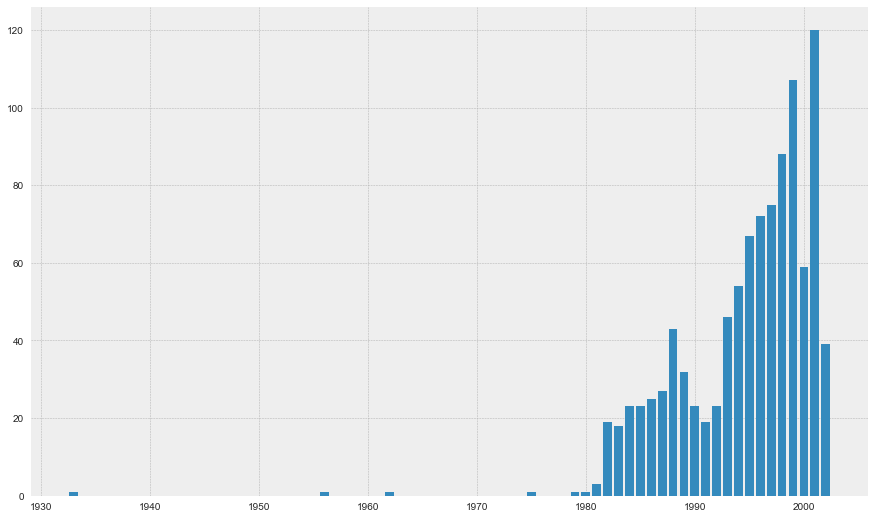

In [167]:
data=movies_df[['year','imdbId']].groupby('year').size()
f,ax=plt.subplots(figsize=(15,9))
plt.bar(data.keys(),data.values)
plt.show()


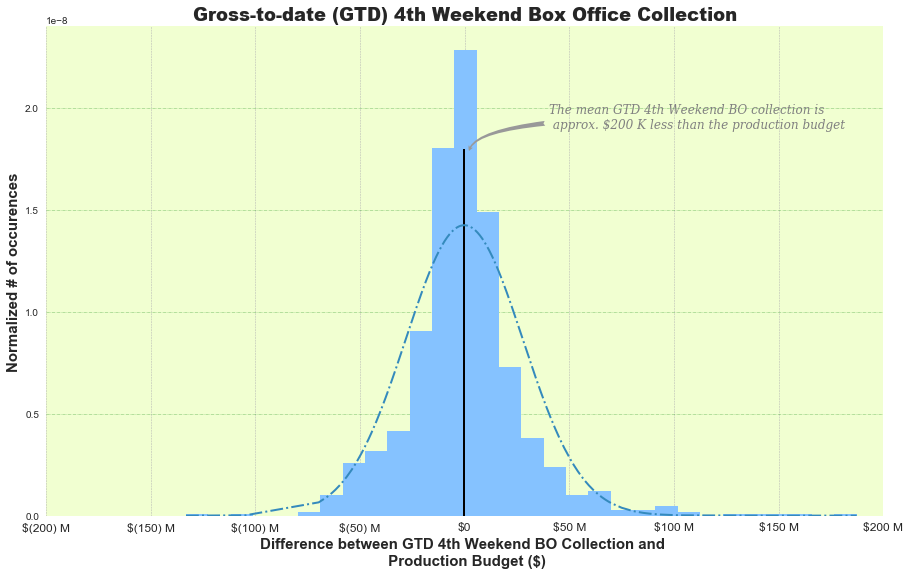

In [176]:
f,ax=plt.subplots(figsize=(15,9))
ax.set_facecolor(color='#f1ffd1')
ax.grid(False, 'major','y', ls='-.', lw=.5, c='g', alpha=.5)

data=sorted(movies_df['prof_loss'])
mean=np.mean(data)

std=np.std(data)
fit = stats.norm.pdf(data, np.mean(data), np.std(data))  #this is a fitting indeed

ax.set_title('Gross-to-date (GTD) 4th Weekend Box Office Collection',fontsize=18,weight='extra bold')
ax.set_xlabel('Difference between GTD 4th Weekend BO Collection and \n Production Budget ($)',fontsize=15,weight='bold')
ax.set_ylabel('Normalized # of occurences',fontsize=15,weight='bold')
xmin,xmax=ax.get_xbound()
ymin,ymax=ax.get_ybound()
ax.set_xlim(-2e8,2e8)
ax.set_xticklabels(['$(200) M','$(150) M','$(100) M','$(50) M','$0','$50 M','$100 M','$150 M','$200 M'],fontsize=12)


ax.annotate('The mean GTD 4th Weekend BO collection is \n approx. $200 K less than the production budget',
            xy=(0.02e8,1.78e-8), xycoords='data',color='grey',
            xytext=(80, 50), textcoords='offset points',
            size=12,
            arrowprops=dict(arrowstyle="fancy",
                            fc="0.6", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-90"),
            horizontalalignment='left', verticalalignment='top',family='serif',style='italic')

#ax.spines['bottom'].set_smart_bounds(True)

plt.plot(data,fit,'-.')
plt.hist(data,bins=30,normed=True,color='#85C2FF')
plt.vlines(mean,ymin,1.8e-8)
ax.spines['top'].set_visible(True)
plt.show()

The above chart shows the distribution of the difference between the gross-to-date (GTD) box office collection and the movie production budget. The distribution roughly follows a Normal distribution and on an average, the movies GTD 4th weekend collection is approximately \$1 Million less than the production budget. At the extremes, there are few movies that have made as much as \$250 Million more than the production budget and there are few that are short by $150 M compared to the production budget.

In [177]:
#mean from the above chart
mean

-212028.75766567755

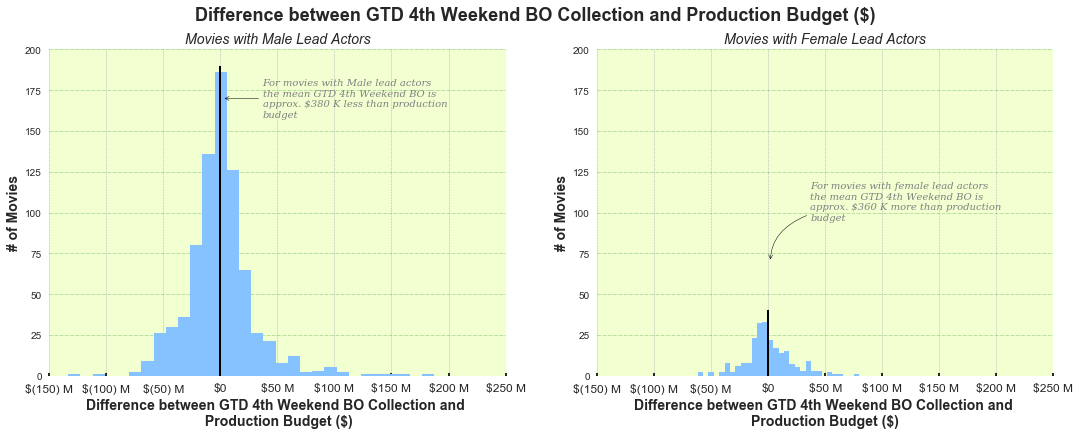

In [180]:
f,ax=plt.subplots(nrows=1, ncols=2,figsize=(18,6))
ax0, ax1 = ax.flatten()
top=200
btm=0.0
lft=-1.5e8
rght=2.5e8

plt.suptitle('Difference between GTD 4th Weekend BO Collection and Production Budget ($)',fontsize=18,weight='bold')


m_data=movies_df[movies_df['actor1_gender']=='Male']['prof_loss']
m_mean=np.mean(m_data)

ax0.set_facecolor(color='#f1ffd1')
ax0.grid(False, 'major','y', ls='-.', lw=.5, c='g', alpha=.5)
ax0.set_title('Movies with Male Lead Actors',fontsize=14,style='italic')
ax0.set_xlabel('Difference between GTD 4th Weekend BO Collection and \n Production Budget ($)',fontsize=14,weight='bold')
ax0.set_ylabel('# of Movies',fontsize=14,weight='bold')
ax0.set_xlim(left=lft,right=rght,auto=False)
ax0.set_xticklabels(['$(150) M','$(100) M','$(50) M','$0','$50 M','$100 M','$150 M','$200 M','$250 M'],fontsize=12)
ax0.set_ylim(bottom=btm,top=top,auto=False)
ax0.annotate('For movies with Male lead actors \nthe mean GTD 4th Weekend BO is \napprox. $380 K less than production\nbudget',
            xy=(0.02e8,top*0.85), xycoords='data',color='grey',
            xytext=(40, 20), textcoords='offset points',
            size=10,
            arrowprops=dict(arrowstyle="->",
                            fc="grey", ec="k",
                            connectionstyle="angle3,angleA=0,angleB=-90"),
            horizontalalignment='left', verticalalignment='top',family='serif',style='italic')
ax0.tick_params('x', length=3, width=2, which='major')

ax0.hist(m_data,bins=30,color='#85C2FF')
ax0.vlines(mean,0,top*0.95)



f_data=movies_df[movies_df['actor1_gender']=='Female']['prof_loss']
f_mean=np.mean(f_data)

ax1.set_facecolor(color='#f1ffd1')
ax1.grid(False, 'major','y', ls='-.', lw=.5, c='g', alpha=.5)
ax1.set_title('Movies with Female Lead Actors',fontsize=14,style='italic')
ax1.set_xlabel('Difference between GTD 4th Weekend BO Collection and \nProduction Budget ($)',fontsize=14,weight='bold')
ax1.set_ylabel('# of Movies',fontsize=14,weight='bold')
ax1.set_xlim(left=lft,right=rght,auto=False)
ax1.set_xticklabels(['$(150) M','$(100) M','$(50) M','$0','$50 M','$100 M','$150 M','$200 M','$250 M'],fontsize=12)
ax1.set_ylim(bottom=btm,top=top,auto=False)
#ax1.text(0.4e8,top*0.35,'$\mu=%.0f$' %(f_mean))
ax1.tick_params('x', length=3, width=2, which='major')
ax1.annotate('For movies with female lead actors \nthe mean GTD 4th Weekend BO is \napprox. $360 K more than production\nbudget',
            xy=(0.02e8,top*0.35), xycoords='data',color='grey',
            xytext=(40, 80), textcoords='offset points',
            size=10,
            arrowprops=dict(arrowstyle="->",
                            fc="grey", ec="k",
                            connectionstyle="angle3,angleA=0,angleB=-90"),
            horizontalalignment='left', verticalalignment='top',family='serif',style='italic')

#ax1.plot(f_data,fit,'-.')
ax1.hist(f_data,bins=30,color='#85C2FF')
ax1.vlines(mean,0,top*0.2)


plt.show()

The bove charts show the difference between the gross-to-date (GTD) 4th weekend box office collection and the movie production budget. The chart on the left shows the chart for movies with male lead actors and the one on the right is for movies with female lead actors. The above charts confirms what everyone suspects that there is huge gender gap in the movie industry with most lead characters being played by male. ** The suprising fact is that the movies with female lead actors are more successful than the ones with male lead actor. ** The 4th weekend GTD box office collection for movies with female lead actors is \$ 560 K more than the production budget, whereas, the same for a movie with a male lead actor is \$1.5 Million less than the production budget.

In [179]:
m_mean,f_mean

(-380170.72250639385, 362150.3537117904)

In [181]:
movies_df['pcnt_prof_loss'].describe()

count    1011.000000
mean        1.935520
std        42.367871
min        -0.970242
25%        -0.506605
50%        -0.065685
75%         0.667445
max      1333.162133
Name: pcnt_prof_loss, dtype: float64

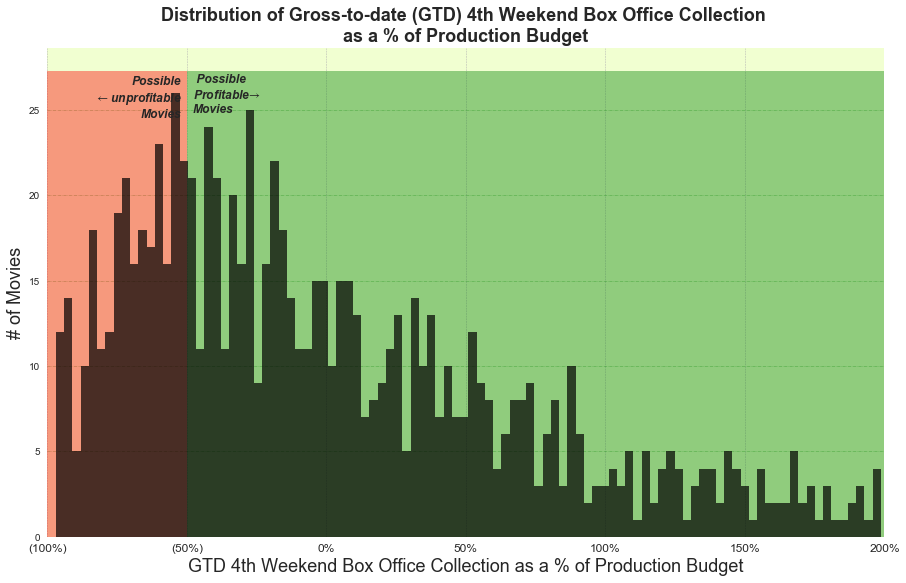

In [182]:
f,ax=plt.subplots(figsize=(15,9))
ax.set_facecolor(color='#f1ffd1')
ax.grid(False, 'major','y', ls='-.', lw=.5, c='g', alpha=.5)

#include all movies whose 4th weekend box office collection is less than
#200% of the production budget, the rest are considered outliers
data=(movies_df[movies_df['pcnt_prof_loss']<2]['pcnt_prof_loss'])


ax.set_title('Distribution of Gross-to-date (GTD) 4th Weekend Box Office Collection \nas a % of Production Budget',
             fontsize=18,weight='bold')
ax.set_xlabel('GTD 4th Weekend Box Office Collection as a % of Production Budget',fontsize=18)
ax.set_xlim(-1,2)
ax.set_xticklabels(['(100%)','(50%)','0%','50%','100%','150%','200%'],fontsize=12)
ax.set_ylabel('# of Movies',fontsize=18)


#plt.text(0,0.8,'$\mu=%.2f$ percent' %(mean*100))

#plt.plot(data,fit,'-.',linewidth=4)
plt.hist(data,bins=100,normed=False,color='k',alpha=0.7)
#plt.vlines(mean,ymin,0.8)
xmin,xmax=ax.get_xlim()
ymin,ymax=ax.get_ylim()

ax.fill_between([xmin,-0.5], ymin,ymax, facecolor='red', alpha = .4, interpolate=True)
plt.text(-.52,.9*ymax,'Possible\n$\u2190$ unprofitable\nMovies',horizontalalignment='right',style='italic',weight='bold')
plt.text(-0.48,.91*ymax,' Possible\nProfitable$\u2192$ \nMovies',horizontalalignment='left',style='italic',weight='bold')

ax.fill_between([-0.5,xmax], ymin,ymax, facecolor='green', alpha = .4, interpolate=True)
plt.show()

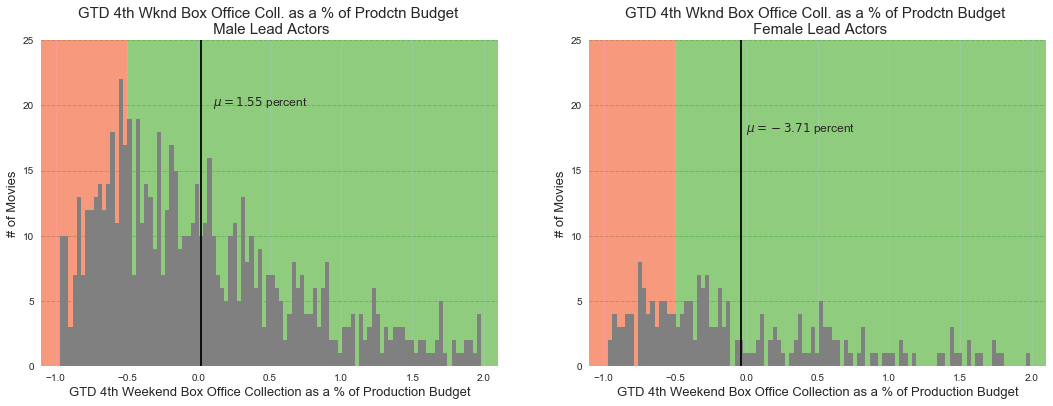

In [98]:
temp_df=movies_df[movies_df['pcnt_prof_loss']<2]

f,ax=plt.subplots(nrows=1, ncols=2,figsize=(18,6))
ax0, ax1 = ax.flatten()
top=25
btm=0.0
lft=-1.1
rght=2.1
#For Male Lead Actor
ax0.set_facecolor(color='#f1ffd1')
ax0.grid(False, 'major','y', ls='-.', lw=.5, c='g', alpha=.5)

data=temp_df[temp_df.actor1_gender=='Male']['pcnt_prof_loss']
mean=np.mean(data)

ax0.hist(data,bins=100,color='grey')

ax0.set_title('GTD 4th Wknd Box Office Coll. as a % of Prodctn Budget \n Male Lead Actors',fontsize=15)
ax0.set_xlabel('GTD 4th Weekend Box Office Collection as a % of Production Budget',fontsize=13)
ax0.set_ylabel('# of Movies',fontsize=13)
ax0.text(.1,20,'$\mu=%.2f$ percent' %(mean*100))
ax0.set_xlim(left=lft,right=rght,auto=False)
ax0.set_ylim(bottom=btm,top=top,auto=False)
#xmin,xmax=ax0.get_xlim()
#ymin,ymax=ax0.get_ylim()
ax0.vlines(mean,btm,50)


ax0.fill_between([lft,-0.5], btm,top, facecolor='red', alpha = .4, interpolate=True)
ax0.fill_between([-0.5,rght], btm,top, facecolor='green', alpha = .4, interpolate=True)

#For Female Lead Actor
ax1.set_facecolor(color='#f1ffd1')
ax1.grid(False, 'major','y', ls='-.', lw=.5, c='g', alpha=.5)

data=temp_df[temp_df.actor1_gender=='Female']['pcnt_prof_loss']
mean=np.mean(data)

ax1.hist(data,bins=100,color='grey')

ax1.set_title('GTD 4th Wknd Box Office Coll. as a % of Prodctn Budget \n Female Lead Actors',fontsize=15)
ax1.set_xlabel('GTD 4th Weekend Box Office Collection as a % of Production Budget',fontsize=13)
ax1.set_ylabel('# of Movies',fontsize=13)
ax1.text(0,18,'$\mu=%.2f$ percent' %(mean*100))
ax1.set_xlim(left=lft,right=rght,auto=False)
ax1.set_ylim(bottom=btm,top=top,auto=False)

ax1.vlines(mean,btm,50)
xmin,xmax=ax1.get_xlim()
ymin,ymax=ax1.get_ylim()

ax1.fill_between([lft,-0.5], ymin,ymax, facecolor='red', alpha = .4, interpolate=True)
ax1.fill_between([-0.5,rght], ymin,ymax, facecolor='green', alpha = .4, interpolate=True)

plt.show()

In [190]:
temp_df=movies_df[['release_date_upd','pcnt_prof_loss']]
temp_df['rel_month']=temp_df['release_date_upd'].apply(lambda x:calendar.month_abbr[x.month])
temp_df=temp_df[temp_df.pcnt_prof_loss<2]

C:\Anac\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


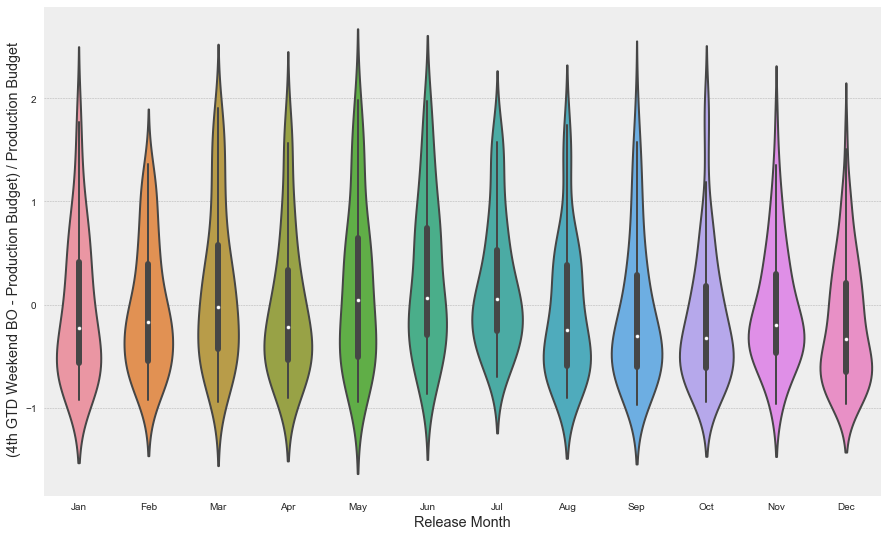

In [191]:
f,ax=plt.subplots(figsize=(15,9))
plt.style.use('bmh')
sns.violinplot(x=temp_df['rel_month'],y=temp_df['pcnt_prof_loss'],
               order=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax.set_xlabel('Release Month')
ax.set_ylabel(' (4th GTD Weekend BO - Production Budget) / Production Budget')
plt.show()

In [192]:
#excluding 2 directors who are outliers
(movies_df['director_score']>100).sum()

0

In [193]:
#excluding 2 directors who are outliers
temp_df=movies_df[movies_df['director_score']<100]

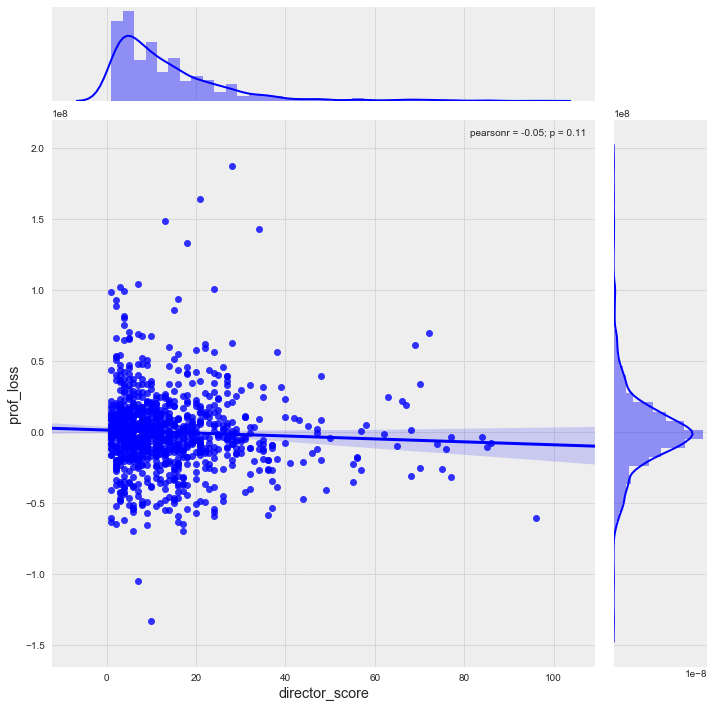

In [194]:
sns.jointplot(temp_df['director_score'], temp_df['prof_loss'],  kind="reg", color="b", size=10)
plt.show()
#plt.tight_layout()

In [195]:
movies_df['actor1_score'].describe()

count    1011.000000
mean       33.454006
std        22.111343
min         1.000000
25%        19.000000
50%        29.000000
75%        43.000000
max       220.000000
Name: actor1_score, dtype: float64

In [196]:
#excluding 13 actor1 who are outliers
(movies_df['actor1_score']>100).sum()

11

In [197]:
#excluding 13 actor1 who are outliers
temp_df=movies_df[movies_df['actor1_score']<100]

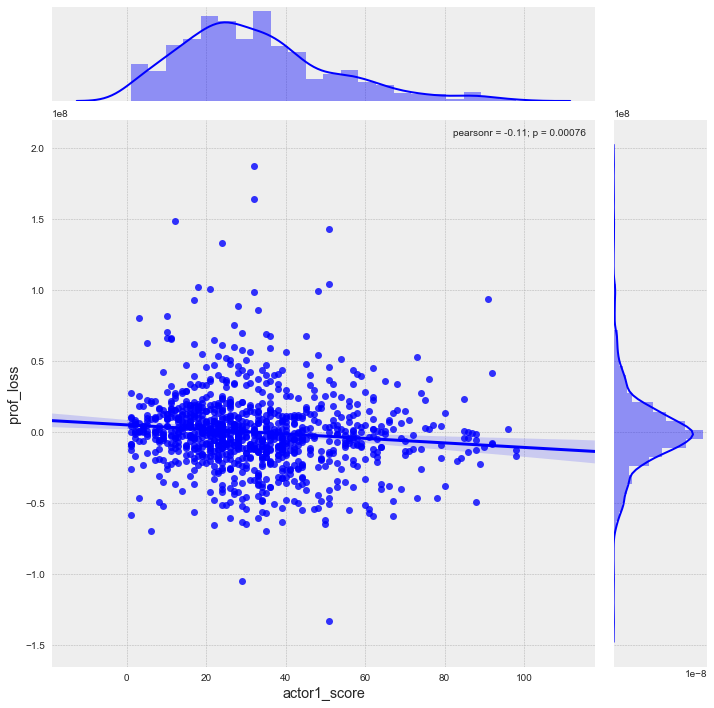

In [198]:
sns.jointplot(temp_df['actor1_score'], temp_df['prof_loss'],  kind="reg", color="b", size=10)
plt.show()

In [227]:
#excluding outliers
temp_df=movies_df[movies_df['pcnt_prof_loss']<3]

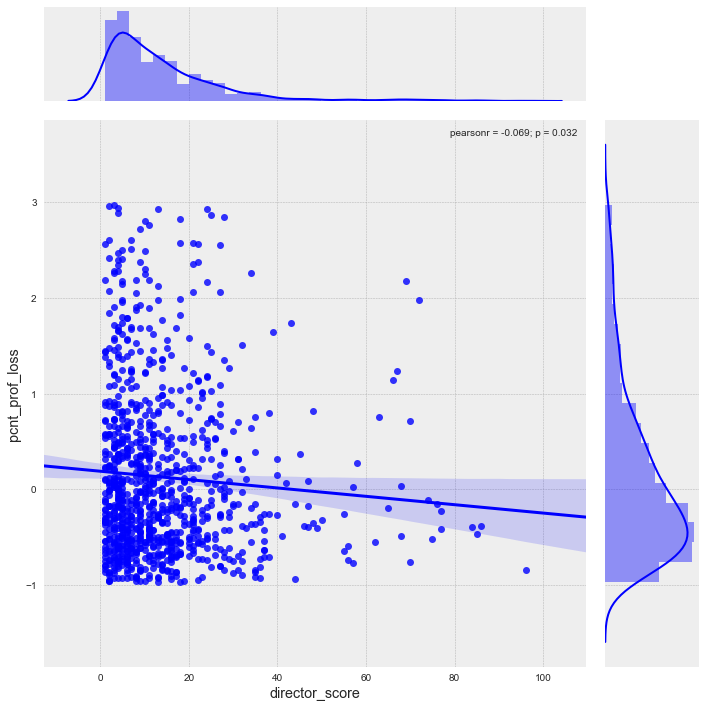

In [228]:
sns.jointplot(temp_df['director_score'], temp_df['pcnt_prof_loss'],  kind="reg", color="b", size=10)
plt.show()

In [233]:
temp_df=movies_df[movies_df['pcnt_prof_loss']<3]

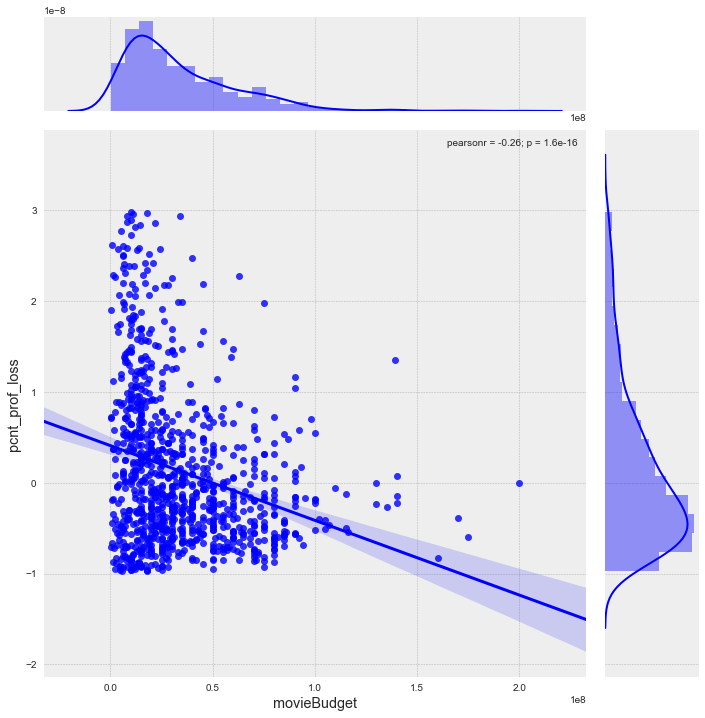

In [234]:
sns.jointplot(temp_df['movieBudget'], temp_df['pcnt_prof_loss'],  kind="reg", color="b", size=10)
plt.show()

In [202]:
temp_df=movies_df[movies_df['pcnt_prof_loss']<3]
temp_df=temp_df[temp_df['year']>1980]

source = ColumnDataSource(data=dict(
    x1=temp_df['actor1_score'],
    x2=temp_df['actor2_score'],
    x3=temp_df['actor3_score'],
    x4=temp_df['actor4_score'],
    x5=temp_df['director_score'],
    y=temp_df['pcnt_prof_loss'],
    size=(abs(temp_df['prof_loss'])/1e7)*2,
    desc=temp_df['title'],
    size_desc=temp_df['prof_loss']))

hover = HoverTool(tooltips=[
    ("Movie", "@desc"),
    ("4th Wknd BO (in $)", "@size_desc"),
])

p = figure(plot_width=900, plot_height=600,title="Correlation Between Actors / Directors and Box Office Collection", 
           x_axis_label='Actor / Director Score', 
           y_axis_label='% of 4th Weekend Box office Collection\nCompared the Production Budget',
           tools="pan,wheel_zoom,box_zoom,reset")
p.add_tools(hover)


    
p.circle(x='x1', y='y',size='size',alpha=0.5,legend='Actor 1',source=source,
        color='orange')
p.circle(x='x2', y='y',size='size',alpha=0.5,legend='Actor 2',source=source,
        color='red')
p.circle(x='x3', y='y',size='size',alpha=0.5,legend='Actor 3',source=source,
        color='green')
p.circle(x='x4', y='y',size='size',alpha=0.5,legend='Actor 4',source=source,
        color='blue')
p.circle(x='x5', y='y',size='size',alpha=0.5,legend='Director',source=source,
        color='grey')

p.legend.location = "top_right"
p.legend.click_policy="hide"
show(p)

In [203]:
movies_df['pcnt_prof_loss'].describe()

count    1011.000000
mean        1.935520
std        42.367871
min        -0.970242
25%        -0.506605
50%        -0.065685
75%         0.667445
max      1333.162133
Name: pcnt_prof_loss, dtype: float64

In [205]:
movies_df[(movies_df['pcnt_prof_loss']>5)][['title','movieBudget','movie_4th_wknd_bo']]

,title,movieBudget,movie_4th_wknd_bo
49,"Brothers McMullen, The (1995)",25000,4656069.0
74,Clerks (1994),27575,624630.0
212,Around the World in 80 Days (1956),6000000,42000000.0
224,Swingers (1996),200000,3121408.0
240,Raiders of the Lost Ark (Indiana Jones and the...,18000000,181718672.0
277,Jaws (1975),8000000,49516476.0
321,Air Bud (1997),3000000,20249873.0
335,Chasing Amy (1997),250000,3886506.0
403,Pi (1998),60000,601702.0
409,"Breakfast Club, The (1985)",1000000,19149143.0


In [206]:
movies_df.columns

Index(['imdbId', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
       'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western', 'actor1_gender', 'actor1_name', 'actor1_score',
       'actor2_gender', 'actor2_name', 'actor2_score', 'actor3_gender',
       'actor3_name', 'actor3_score', 'actor4_gender', 'actor4_name',
       'actor4_score', 'director', 'director_score', 'found', 'genres', 'kind',
       'movieBudget', 'movieId', 'movie_4th_wknd_bo', 'movie_details', 'plot',
       'release_date', 'studio', 'title', 'tmdbId', 'year', 'year_orig',
       'prof_loss', 'pcnt_prof_loss', 'release_date_upd', 'actor1_male',
       'actor1_female', 'actor2_male', 'actor2_female', 'actor3_male',
       'actor3_female', 'actor4_male', 'actor4_female', 'Apr', 'Aug', 'Dec',
       'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep'],
      dtype='object')

In [132]:
movies_df=movies_df[movies_df['pcnt_prof_loss']<=10]

In [133]:
movies_df_model_data = movies_df[['imdbId', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
       'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western', 'actor1_score',
        'actor2_score', 'actor3_score',
       'actor4_score', 'director_score', 
       'movieBudget', 'movie_4th_wknd_bo', 
       'year', 
       'Apr', 'Aug', 'Dec',
       'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep',
       'actor1_male', 'actor1_female', 'actor2_male', 'actor2_female',
       'actor3_male', 'actor3_female', 'actor4_male', 'actor4_female','prof_loss', 'pcnt_prof_loss' ]]

In [134]:
movies_df_model_data=movies_df_model_data.set_index('imdbId')

In [135]:
np.sum(np.isnan(movies_df_model_data))

Action               0
Adventure            0
Animation            0
Children             0
Comedy               0
Crime                0
Documentary          0
Drama                0
Fantasy              0
Film-Noir            0
Horror               0
IMAX                 0
Musical              0
Mystery              0
Romance              0
Sci-Fi               0
Thriller             0
War                  0
Western              0
actor1_score         0
actor2_score         0
actor3_score         0
actor4_score         1
director_score       0
movieBudget          0
movie_4th_wknd_bo    0
year                 0
Apr                  0
Aug                  0
Dec                  0
Feb                  0
Jan                  0
Jul                  0
Jun                  0
Mar                  0
May                  0
Nov                  0
Oct                  0
Sep                  0
actor1_male          0
actor1_female        0
actor2_male          0
actor2_female        0
actor3_male

In [136]:
movies_df_model_data['actor4_score'].fillna(0,inplace=True)

In [137]:
np.isnan(movies_df_model_data['actor4_score']).sum()

0

In [138]:
#features
movies_df_model_data.columns[0:46].values

array(['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western', 'actor1_score', 'actor2_score', 'actor3_score',
       'actor4_score', 'director_score', 'movieBudget',
       'movie_4th_wknd_bo', 'year', 'Apr', 'Aug', 'Dec', 'Feb', 'Jan',
       'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep', 'actor1_male',
       'actor1_female', 'actor2_male', 'actor2_female', 'actor3_male',
       'actor3_female', 'actor4_male'], dtype=object)

In [139]:
#to be predicted
movies_df_model_data.columns[48]

'pcnt_prof_loss'

In [140]:
from sklearn.model_selection import train_test_split

In [141]:
train_df, test_df = train_test_split(movies_df_model_data,test_size=0.2,random_state=1)

In [142]:
X_train=train_df[movies_df_model_data.columns[0:46].values]
y_train=train_df['pcnt_prof_loss']
X_test=test_df[movies_df_model_data.columns[0:46].values]
y_test=test_df['pcnt_prof_loss']

In [143]:
#find the sum of squares if we just use mean of 4th weekend percentage
#as the prediction; any model should be better than this
mean=np.mean(y_train)
np.sum((y_train-mean)**2)

1330.9695868953318

In [144]:
from sklearn import linear_model

In [145]:
from sklearn.grid_search import GridSearchCV

In [146]:
clf = linear_model.BayesianRidge(n_iter=2)

In [147]:
clf.fit(X_train,y_train)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=2,
       normalize=False, tol=0.001, verbose=False)

In [148]:
np.sum((clf.predict(X_train)-y_train)**2)

680.0587159821071

In [192]:
parameters = {"alpha_1": [1e-5,1e-6,1e-7,1e-8,0],"lambda_1":[0.01,0.05,.1,.2]}
#parameters = {"alpha_1": [.1,.001,.0001,.00001]}
BRclf=linear_model.BayesianRidge(n_iter=2)

In [193]:
%%time
#fitmodel = GridSearchCV(BRclf, param_grid=parameters, scoring="neg_mean_squared_error")
fitmodel = GridSearchCV(BRclf, param_grid=parameters, scoring="neg_mean_absolute_error")

fitmodel.fit(X_train,y_train)
print('***best estimator:',fitmodel.best_estimator_)
print('***best params:',fitmodel.best_params_)
print('***best score:',fitmodel.best_score_)
print('***grid scores:', fitmodel.grid_scores_)

***best estimator: BayesianRidge(alpha_1=0, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=0.2, lambda_2=1e-06, n_iter=2,
       normalize=False, tol=0.001, verbose=False)
***best params: {'alpha_1': 0, 'lambda_1': 0.2}
***best score: -0.580536626265908
***grid scores: [mean: -0.58059, std: 0.02012, params: {'alpha_1': 1e-05, 'lambda_1': 0.01}, mean: -0.58058, std: 0.02011, params: {'alpha_1': 1e-05, 'lambda_1': 0.05}, mean: -0.58057, std: 0.02011, params: {'alpha_1': 1e-05, 'lambda_1': 0.1}, mean: -0.58054, std: 0.02009, params: {'alpha_1': 1e-05, 'lambda_1': 0.2}, mean: -0.58059, std: 0.02012, params: {'alpha_1': 1e-06, 'lambda_1': 0.01}, mean: -0.58058, std: 0.02011, params: {'alpha_1': 1e-06, 'lambda_1': 0.05}, mean: -0.58057, std: 0.02011, params: {'alpha_1': 1e-06, 'lambda_1': 0.1}, mean: -0.58054, std: 0.02009, params: {'alpha_1': 1e-06, 'lambda_1': 0.2}, mean: -0.58059, std: 0.02012, params: {'alpha_1': 1e-07, 'lambda_1': 0.01}, mean: -0.58

In [194]:
clf=fitmodel.best_estimator_

In [195]:
clf.fit(X_train,y_train)

BayesianRidge(alpha_1=0, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=0.2, lambda_2=1e-06, n_iter=2,
       normalize=False, tol=0.001, verbose=False)

In [196]:
(np.sum((clf.predict(X_train)-y_train)**2))

680.1231709965307

In [197]:
(np.sum((clf.predict(X_train)-y_train)**2))/len(X_train)

0.8490925979981656

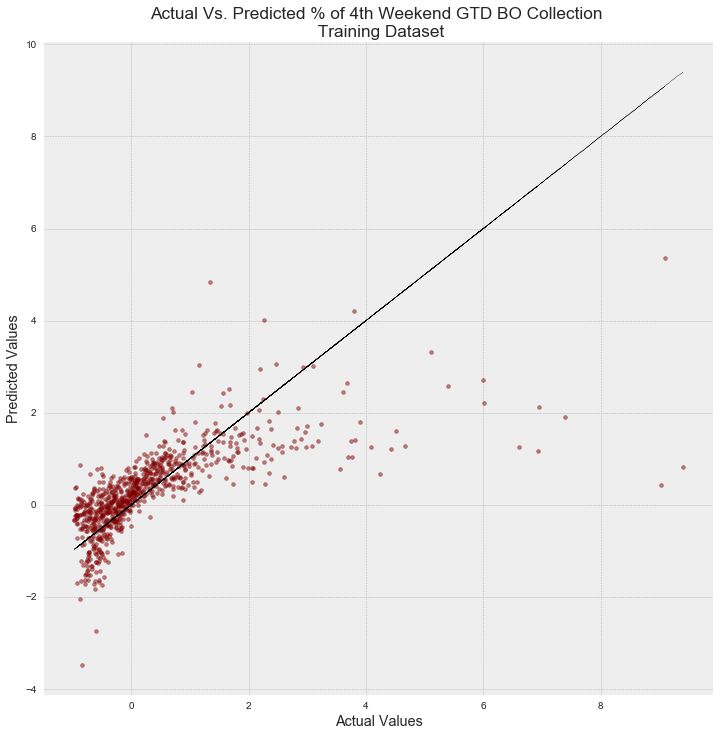

In [198]:
f,ax=plt.subplots(figsize=(12,12))

plt.style.use('bmh')
plt.title('Actual Vs. Predicted % of 4th Weekend GTD BO Collection \n Training Dataset')
#ax.set_xlim(left=-4,right=10,auto=False)
#ax.set_ylim(bottom=-4,top=10,auto=False)
x,y=y_train,clf.predict(X_train)
plt.scatter(x,y,alpha=0.5,s=15,color='maroon')
plt.plot(x,x,color='k',linewidth=0.5,linestyle=':')
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')
plt.show()

In [199]:
(np.sum((clf.predict(X_test)-y_test)**2))/len(X_test)

0.6876702458654962

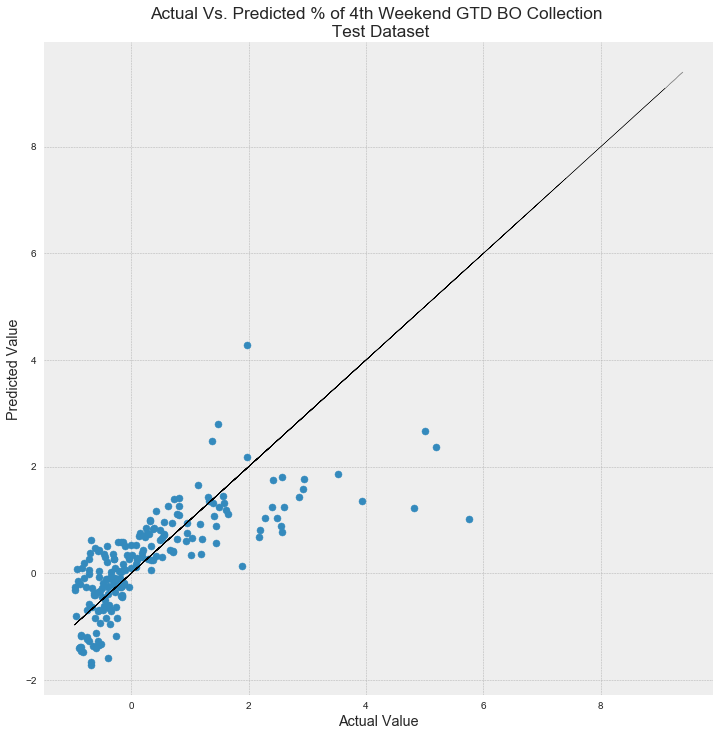

In [201]:
f,ax=plt.subplots(figsize=(12,12))

#plt.style.use('bmh')
plt.title('Actual Vs. Predicted % of 4th Weekend GTD BO Collection \n Test Dataset')
#ax.set_xlim(left=-2,right=6,auto=False)
#ax.set_ylim(bottom=-2,top=6,auto=False)
plt.scatter(x=y_test,y=clf.predict(X_test))
plt.plot(x,x,color='k',linewidth=0.5,linestyle=':')
ax.set_xlabel('Actual Value')
ax.set_ylabel('Predicted Value')
plt.show()